# Dense Body Pose Estimation

A quick intro to using the pre-trained model to detect and segment Body Poses.

In [1]:
import os
import sys
import random
import math
import scipy
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import menpo.io as mio
from keras import backend as K
from pathlib import Path

# Root directory of the project
ROOT_DIR = os.path.abspath("/Users/zha/gitdev/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append("/Users/zha/gitdev/Mask_RCNN/samples/coco/")  # To find local version
sys.path.append("/Users/zha/gitdev/cocoapi/PythonAPI/")
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = "/Users/zha/gitdev/Mask_RCNN/mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = "/Users/zha/gitdev/Mask_RCNN/images"

# menpo imports
from menpo.image import Image
from menpo.shape import PointCloud
from menpo.visualize import print_progress

# deep modules
import deepmachine as dm
from deepmachine.networks import pose
from deepmachine import networks
from deepmachine import utils
from deepmachine import losses
from deepmachine import summary
from deepmachine import data_provider
from deepmachine import contrib
from deepmachine import record_builder
from deepmachine import DeepMachine

import dAAMs

/Users/zha/miniconda2/envs/gitdev/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/zha/miniconda2/envs/gitdev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/zha/miniconda2/envs/gitdev/lib/python3.5/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


## Detector Configurations

In [2]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

## Create Model and Load Trained Weights

In [3]:
model_path = './models/denseRegPose/model.ckpt-574050'
dense_pose_net = contrib.get_dense_pose_net_old()
dense_pose_net.restore_path = model_path

In [4]:
# Create model object in inference mode.
detection_model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
detection_model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

In [5]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Visualisatoin Helper

In [6]:
def view_results(original_image = None, lms_hm_prediction = None, iuv = None, pts_predictions = None):
    
    plt.close()
    f_all = plt.figure(figsize=(10,8))



    f = plt.subplot(221)
    if original_image is not None:
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

        img_pixel = original_image.pixels_with_channels_at_back()
        plt.imshow(img_pixel)



    f = plt.subplot(222)
    if lms_hm_prediction is not None:
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

        if type(lms_hm_prediction) is np.array:
            hm_pixel = np.mean(lms_hm_prediction.squeeze(), axis=-1)
            plt.imshow(hm_pixel)
        else:
            plt.imshow(lms_hm_prediction.pixels_with_channels_at_back())

    
    f = plt.subplot(223)
    if iuv is not None:
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

        if type(iuv) is np.array:
            iuv_pixel = utils.convert.iuv_rgb(iuv, 'hsv')
            plt.imshow(iuv_pixel)
        else:
            plt.imshow(iuv.pixels_with_channels_at_back())

    f = plt.subplot(224)
    if pts_predictions is not None:
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

        plt.scatter(pts_predictions[:,1], pts_predictions[:,0])
        plt.imshow(img_pixel * 0.3 + iuv_pixel * 0.7)

    return f_all

## Run Pose Estimation

In [7]:
def pose_estimation(imagepath, verbose=False):
    # ## Run Object Detection
    
    if verbose:
        print('reading image')
        
    image = Image(mio.import_image(imagepath).pixels) if type(imagepath) is str else imagepath
    # Run detection
    if verbose:
        print('detecting human')
    results = detection_model.detect([image.pixels_with_channels_at_back() * 255], verbose=0)

    # Visualize results
    r = results[0]

    # ## Run Pose Estimation

    # In[20]:
    if verbose:
        print('croping image')
    pose_bboxes = [bb.reshape([2,2]) for bb,cid in zip(r['rois'],r['class_ids']) if cid == 1]
    pose_masks = [m for m,cid in zip(r['masks'].transpose(2,0,1),r['class_ids']) if cid == 1]
    
    def pose_estimation_bb(bb, mask):
        cropped_image, crop_trans, _ = utils.crop_image_bounding_box(image, PointCloud(bb), [384,384])

        h, w = cropped_image.shape
        offset = (384-256)/2

        cropped_image, fit_crop_t = cropped_image.crop((offset,offset),(offset+256,offset+256), return_transform=True)

        input_pixels = cropped_image.pixels_with_channels_at_back()

        if verbose:
            print('dense pose estimation')
        lms_hm_prediction,eps = dense_pose_net.run_one(input_pixels[None, ...].astype(np.float32), )

        bsize,h,w,n_ch = lms_hm_prediction.shape
        lms_hm_prediction_filter = np.stack(list(map(
                                    lambda x: scipy.ndimage.filters.gaussian_filter(*x),
                                    zip(lms_hm_prediction.transpose(0,3,1,2).reshape(-1,h,w), [5] * (bsize * n_ch)))))

        hs = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 2), 1)
        ws = np.argmax(np.max(lms_hm_prediction_filter.squeeze(), 1), 1)
        pts_predictions = np.stack([hs,ws]).T


        # render results
        if verbose:
            print('render results')
        iuv_img = Image.init_from_channels_at_back(utils.convert.iuv_rgb(eps['uv'], 'hsv'))
        svs_shape = dAAMs.utils.multi_channel_svs(PointCloud(pts_predictions), h, w, [
            [0,1,2],[3,4,5],[2,6,3],[6,7,8,9],[10,11,12],[13,14,15],[12,7,13]
        ], c = 5)
        svs_shape = Image.init_from_channels_at_back(
            utils.svs_rgb(svs_shape.pixels_with_channels_at_back())
        )
        heatmap = Image.init_from_channels_at_back(
            utils.svs_rgb(utils.lms_to_heatmap(pts_predictions, h, w).transpose([1,2,0]))
        )
        # restore
        restore_trans = fit_crop_t.compose_before(crop_trans)
        iuv_orig = iuv_img.warp_to_shape(image.shape[:2], restore_trans.pseudoinverse())
        svs_orig = svs_shape.warp_to_shape(image.shape[:2], restore_trans.pseudoinverse())
        heatmap_orig = heatmap.warp_to_shape(image.shape[:2], restore_trans.pseudoinverse())

        return {
            'image_crop': cropped_image,
            'iuv_crop': iuv_img,
            'svs_crop': svs_shape,
            'heatmap_crop': heatmap,
            'restore_trans': restore_trans,
            'image': image,
            'iuv': iuv_orig,
            'svs': svs_orig,
            'heatmap': heatmap_orig,
            'mask': mask
        }
    
    return [pose_estimation_bb(bbox, mask) for bbox, mask in zip(pose_bboxes, pose_masks)]

In [16]:
input_image = mio.import_image('./resources/pose_me.jpg')
results = pose_estimation(input_image)

In [17]:
final_image_iuv = Image(
   results[0]['image'].pixels * 0.3 + 0.7*sum([r['iuv'].pixels * r['mask'][None, ...] for r in results])
)
final_image_iuv.pixels = final_image_iuv.pixels.clip(0,1)

final_image_hm = Image(
   results[0]['image'].pixels * 0.3 + 0.7*sum([r['heatmap'].pixels for r in results])
)
final_image_hm.pixels = final_image_hm.pixels.clip(0,1)

final_image_svs = Image(
   results[0]['image'].pixels * 0.3 + 0.7*sum([r['svs'].pixels for r in results])
)
final_image_svs.pixels = final_image_svs.pixels.clip(0,1)

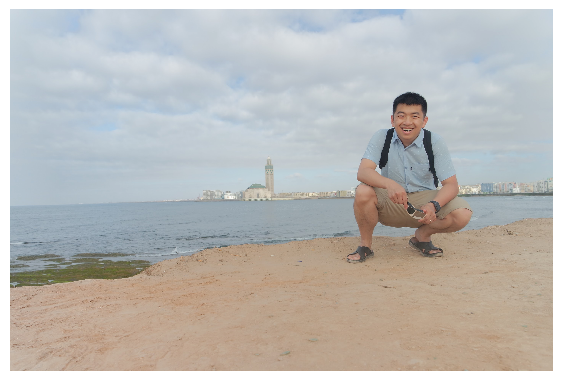

In [18]:
input_image.view()

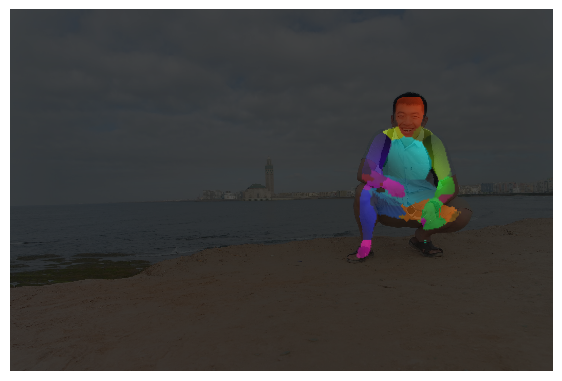

In [19]:
final_image_iuv.view()

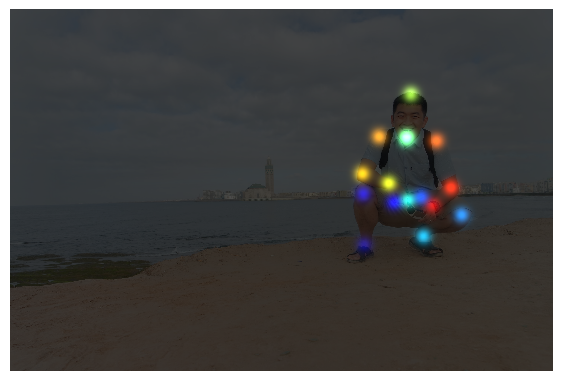

In [20]:
final_image_hm.view()

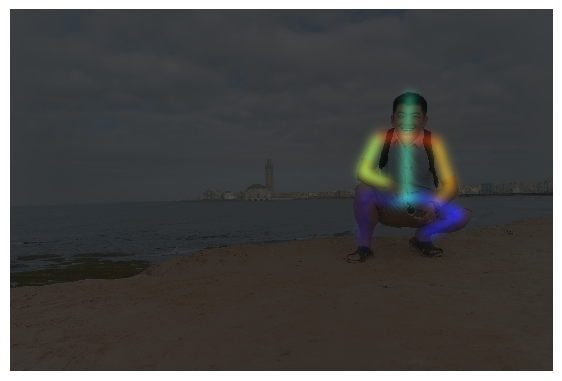

In [21]:
final_image_svs.view()